In [1]:
%cd ..


/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)

# training the model

In [3]:
def scale_columns(df, cols):

    # Create a scaler object
    scaler = StandardScaler()

    # Scale the specified columns in the dataframe
    df_scaled = df.copy()
    df_scaled[cols] = scaler.fit_transform(df[cols])

    return df_scaled


def report_feature_importances(model, X_train):

    # Get the feature importances
    importances = model.feature_importances_

    # Create a dataframe of feature importances
    feature_importances = pd.DataFrame(
        {"feature": X_train.columns, "importance": importances})

    # Sort the dataframe by feature importance in descending order
    feature_importances = feature_importances.sort_values(
        "importance", ascending=False)

    # Add a new column for cumulative importance
    feature_importances["cumulative_importance"] = feature_importances["importance"].cumsum()

    return feature_importances


def calculate_elbow_point(model, X_train):
    """ identifies the elbow point for the model and returns the features with low importance"""

    # Report the feature importances for the  model
    feature_importances = report_feature_importances(model, X_train)

    # Sort the feature importances by importance in descending order
    feature_importances = feature_importances.sort_values(
        "importance", ascending=False)

    # Calculate the cumulative sum of feature importances
    feature_importances["cumulative_importance"] = feature_importances["importance"].cumsum()

    # Identify the elbow point
    elbow_point = feature_importances[feature_importances["cumulative_importance"]
                                      >= 0.9 * feature_importances["importance"].sum()].iloc[0]["feature"]

    return list(feature_importances[feature_importances["feature"] > elbow_point]["feature"])

In [4]:
df = pd.read_csv("results/5_features.csv")
df.head()

,mrna_start,mrna_end,pred_energy,mirna_start,mirna_end,mirna_dot_bracket_5to3,mirna_sequence,mirna_accession,mre_region,enst,label,alignment_string,pred_num_basepairs,pred_seed_basepairs,ta_log10,sps_mean,anchor_a,6mer_seed,match_8,6mer_seed_1_mismatch,compensatory_site,supplementary_site,supplementary_site_2,empty_seed,9_consecutive_match_anywhere,mirna_conservation,midpoint,close_proximity
0,23,46,-27.7,1,21,)))))))))))))))))))).,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,TTTATACAGAACCTACTGCCTC,ENST00000340828,1,1111111111111111111100,20,6,3.393,-8.18,0,1,1,0,1,1,0,0,1,2.0,27,0
1,12,31,-26.2,1,19,))))))))).)))))))).,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,CGTGCAACCAACTACCTCATAT,ENST00000343455,1,1111111110111111110000,17,6,3.393,-8.18,0,1,1,0,1,1,0,0,1,2.0,16,0
2,4,25,-23.6,1,22,.)))))).))))))))))))).,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,CGCTATATGACCTGATGCCTTT,ENST00000436639,1,0111111011111111111110,19,6,3.393,-8.18,0,1,0,0,1,1,1,0,1,2.0,8,0
3,4,25,-23.8,1,22,)))))))...)))))))))))),TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,TGACTATGCAACCATACCTTAC,ENST00000282516,1,1111111000111111111111,19,6,3.393,-8.18,0,1,0,0,1,1,1,0,1,2.0,8,0
4,3,25,-24.0,1,22,))))))))))))))...)))).,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,TACTGGGAAACCTGCTACTTCG,ENST00000340139,1,1111111111111100011110,18,6,3.393,-8.18,0,1,1,0,0,0,0,0,1,2.0,7,0


In [5]:
# Drop irrelevant columns
cols_to_drop = ["mrna_start", "mrna_end", "mirna_start", "mirna_end",
                "mirna_dot_bracket_5to3", "mirna_sequence", "mirna_accession",
                "mre_region", "enst", "alignment_string"]
df = df.drop(cols_to_drop, axis=1)

# # Scaling columns
cols_to_scale = ["ta_log10", "sps_mean", "midpoint"]
# df = scale_columns(df, cols_to_scale)

# Train test split
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Init model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(score)

0.9862059546571975


# feature importances

In [6]:
report_df = report_feature_importances(model, X_train)
report_df

,feature,importance,cumulative_importance
0,pred_energy,0.547718,0.547718
14,mirna_conservation,0.113974,0.661692
15,midpoint,0.071337,0.733029
12,empty_seed,0.069671,0.802700
1,pred_num_basepairs,0.036872,0.839572
3,ta_log10,0.034203,0.873775
4,sps_mean,0.033623,0.907398
13,9_consecutive_match_anywhere,0.018355,0.925753
2,pred_seed_basepairs,0.017258,0.943011
7,match_8,0.014297,0.957308


In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def drop_column_and_score(X, y):
    scores = {}

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train an initial XGBoost model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    initial_score = accuracy_score(y_test, model.predict(X_test))
    scores['initial_model'] = initial_score

    # Drop each column one by one and train a new model
    for column in X.columns:
        # Create a new X without the current column
        X_dropped = X.drop(column, axis=1)

        # Split the modified data into train and test sets
        X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

        # Train a new XGBoost model without the current column
        model_dropped = xgb.XGBClassifier()
        model_dropped.fit(X_train_dropped, y_train)

        # Calculate the score of the new model
        score = accuracy_score(y_test, model_dropped.predict(X_test_dropped))
        scores[column] = score

    return scores

drop_column_and_score(X, y)


{'initial_model': 0.9862059546571975,
 'pred_energy': 0.9811526905217154,
 'pred_num_basepairs': 0.9859328052444687,
 'pred_seed_basepairs': 0.9875717017208413,
 'ta_log10': 0.9852499317126469,
 'sps_mean': 0.9857962305381044,
 'anchor_a': 0.9868888281890194,
 '6mer_seed': 0.9871619776017482,
 'match_8': 0.9883911499590275,
 '6mer_seed_1_mismatch': 0.98565965583174,
 'compensatory_site': 0.9857962305381044,
 'supplementary_site': 0.9860693799508331,
 'supplementary_site_2': 0.9870254028953838,
 'empty_seed': 0.986752253482655,
 '9_consecutive_match_anywhere': 0.9866156787762906,
 'mirna_conservation': 0.9871619776017482,
 'midpoint': 0.9819721387599016,
 'close_proximity': 0.9866156787762906}

In [16]:
asd = drop_column_and_score(X, y)



In [21]:
bb = asd.values().tolist()

bb.sort()

AttributeError: 'dict_values' object has no attribute 'tolist'

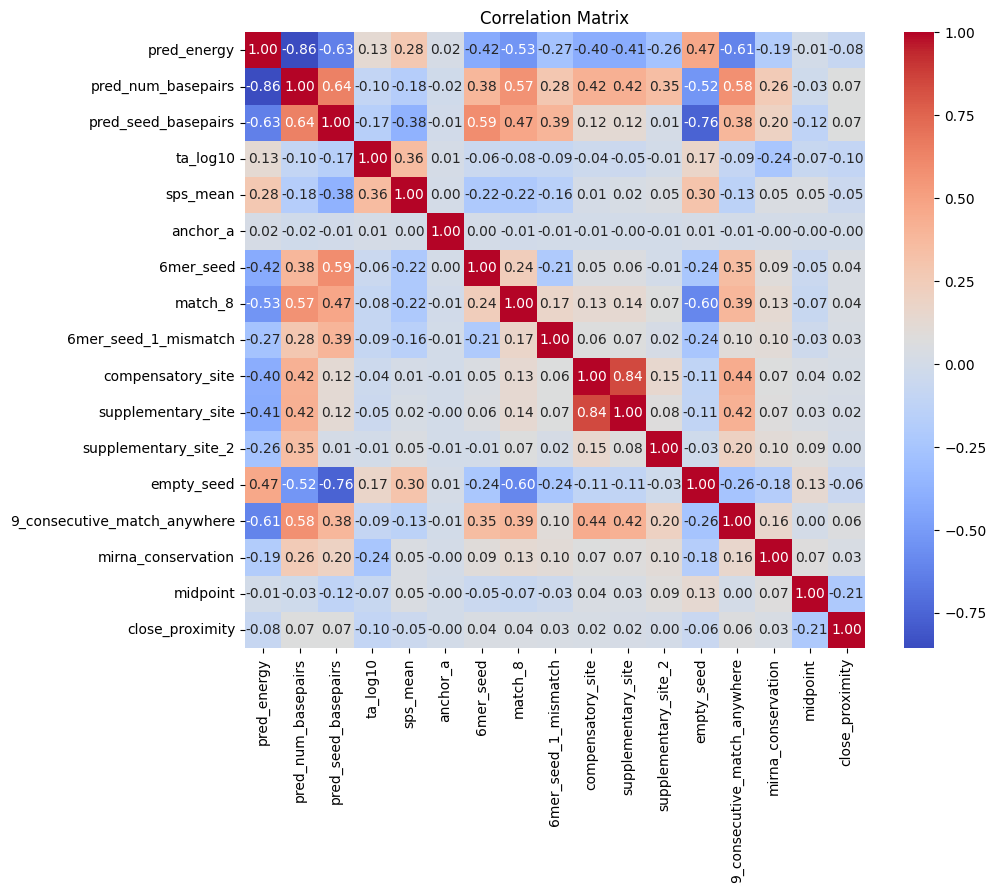

In [8]:
import pandas as pd

# Assuming your features are stored in a DataFrame called 'data'
correlation_matrix = X.corr()


import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [9]:
import pandas as pd
import numpy as np


def find_most_correlated_features(data, threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = data.corr().abs()

    # Extract the upper triangle of the correlation matrix
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Find feature pairs with correlation above the threshold
    correlated_pairs = upper_triangle.unstack().sort_values(ascending=False)
    correlated_pairs = correlated_pairs[correlated_pairs > threshold]

    return correlated_pairs

find_most_correlated_features(X)


pred_num_basepairs  pred_energy            0.856532
supplementary_site  compensatory_site      0.842683
empty_seed          pred_seed_basepairs    0.755526
dtype: float64

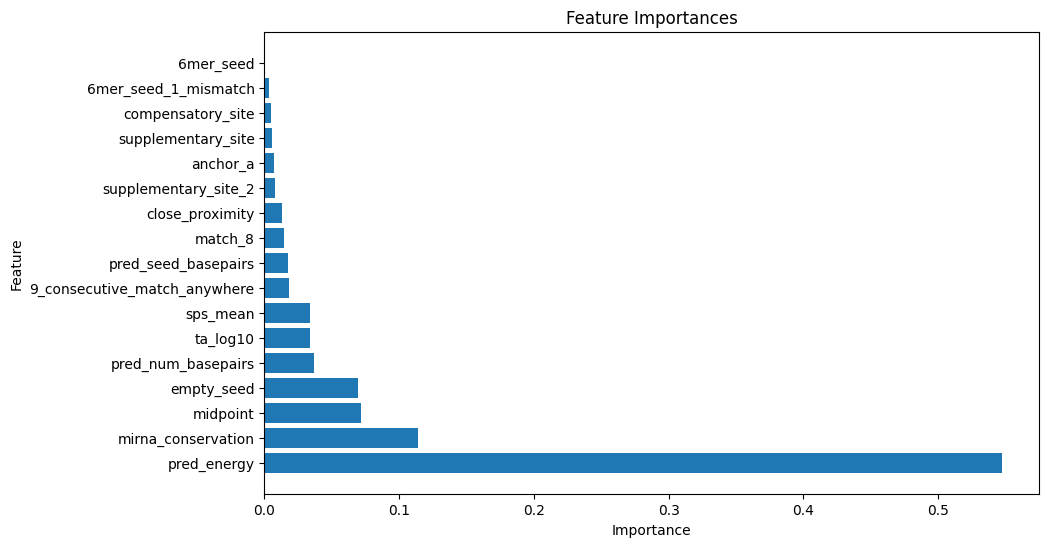

In [10]:
import matplotlib.pyplot as plt

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(report_df['feature'], report_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


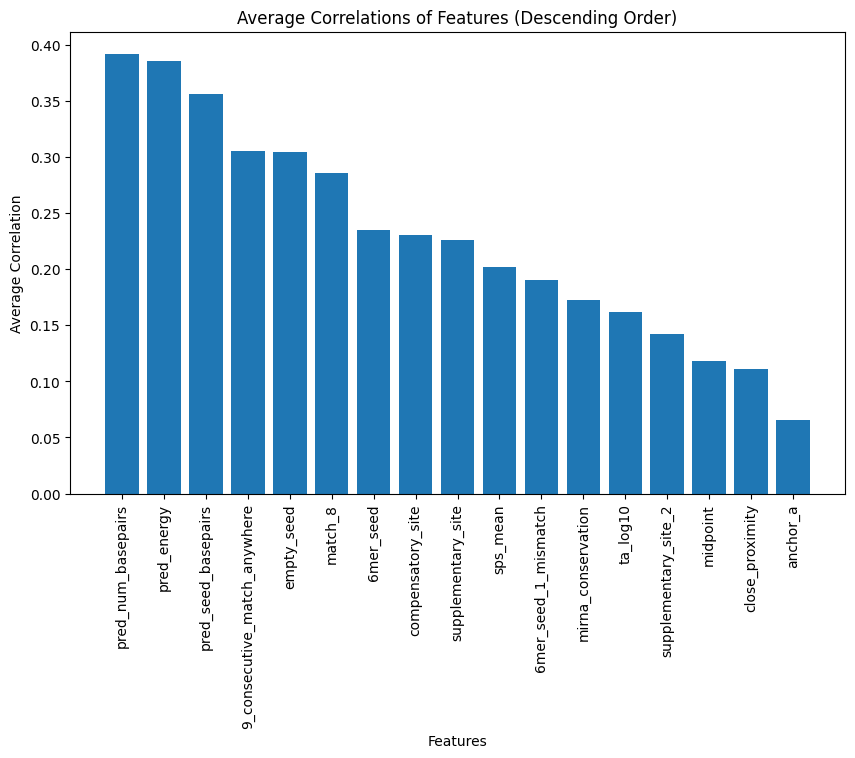

In [11]:
def get_average_correlations(df: pd.DataFrame) -> pd.Series:
    return df.corr().abs().mean()

avgcorr = get_average_correlations(X)

avgcorr = avgcorr.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(avgcorr.index, avgcorr.values)
plt.xlabel('Features')
plt.ylabel('Average Correlation')
plt.title('Average Correlations of Features (Descending Order)')
plt.xticks(rotation=90)
plt.show()


# GridSearchCV


In [12]:
# param_grid = {
#     "max_depth": [3, 4, 5],
#     "learning_rate": [0.01, 0.1, 0.5],
#     "n_estimators": [100, 500, 1000]
# }

# grid_search = GridSearchCV(
#     estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best hyperparameters: ", grid_search.best_params_)
# print("Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

Accuracy: 98.25%

In [13]:
# model_after_cv = xgb.XGBClassifier(**grid_search.best_params_)

# model_after_cv.fit(X_train, y_train)
# score_after_cv = model_after_cv.score(X_test, y_test)
# print(f"accuracy after cv: {score_after_cv}")

In [14]:
# scores = {
#     "model": model.score(X_test, y_test),
#     "model_after_cv": model_after_cv.score(X_test, y_test)
# }


# for i, (ml_model, score) in enumerate(scores.items()):
#     plt.scatter(i, score, s=200)

# plt.xticks(range(len(scores)), list(scores.keys()))
# plt.ylabel("Accuracy Score")
# plt.title("Model Accuracy Scores")

# plt.show()

In [15]:
# percentage_increase = (model_after_cv.score(X_test, y_test) - model.score(X_test, y_test)) / model.score(X_test, y_test) * 100

# print(f"The accuracy increased by {percentage_increase:.2f}% after CV")
